In [1]:
import livef1

livef1.set_log_level('INFO')

session = livef1.get_session(
   season=2024,
   meeting_identifier="Spa",
   session_identifier="Race"
   )

03:17:51 - Selected meeting/session is:
	Meeting Offname : FORMULA 1 ROLEX BELGIAN GRAND PRIX 2024
	Meeting Name : Belgian Grand Prix
	Meeting Circuit Shortname : Spa-Francorchamps
03:17:51 - Got the meeting.
03:17:51 - Selected meeting/session is:
	Session Name : Race
03:17:51 - The session was received successfully.


In [3]:
import livef1
import pandas as pd
import matplotlib.pyplot as plt

livef1.set_log_level("info")

# Get the session
session = livef1.get_session(
    season=2024,
    meeting_identifier="Spa",
    session_identifier="Race"
)

# Generate silver tables
session.generate(silver=True)

16:27:28 - Selected meeting/session is:
	Meeting Offname : FORMULA 1 ROLEX BELGIAN GRAND PRIX 2024
	Meeting Name : Belgian Grand Prix
	Meeting Circuit Shortname : Spa-Francorchamps
16:27:28 - Got the meeting.
16:27:28 - Selected meeting/session is:
	Session Name : Race
16:27:28 - The session was received successfully.


['TimingData', 'CarData.z', 'Position.z', 'SessionStatus']


16:27:52 - Silver tables are being generated.
16:27:55 - 'laps' has been generated and saved to the silver lake. You can access it from 'session.laps'.
16:28:10 - 'car_telemetry' has been generated and saved to the silver lake. You can access it from 'session.car_telemetry'.


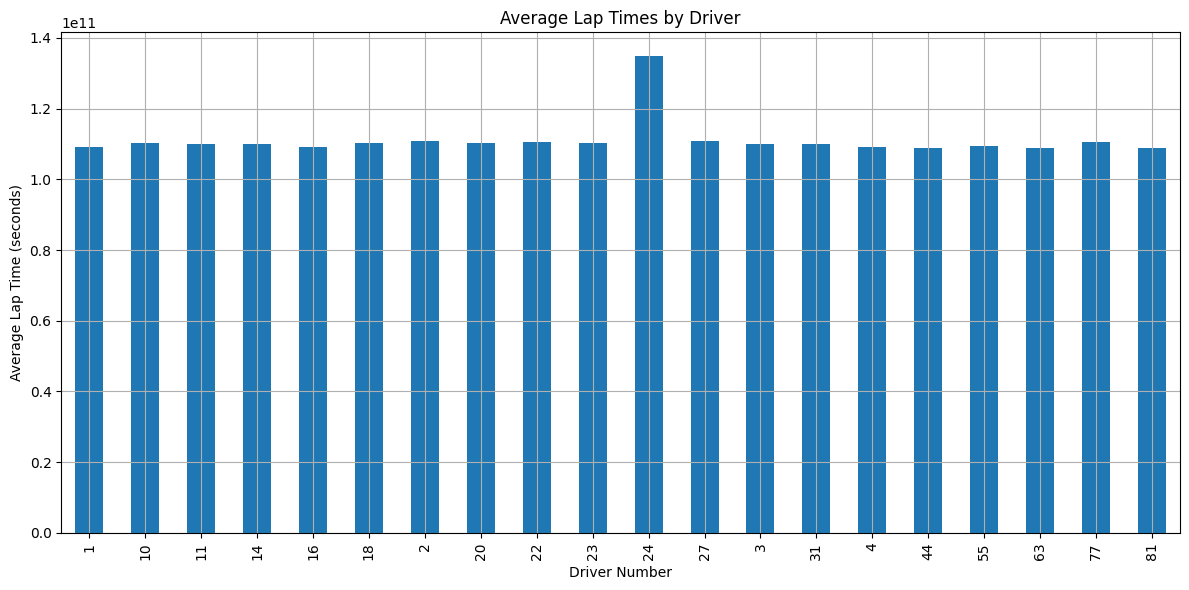

In [9]:
# Get lap times data
df = session.get_laps()

# Calculate average lap times per driver
avg_lap_times = df.groupby('DriverNo')['lap_time'].mean()

# Visualize the results
plt.figure(figsize=(12, 6))
avg_lap_times.plot(kind='bar')
plt.title('Average Lap Times by Driver')
plt.xlabel('Driver Number')
plt.ylabel('Average Lap Time (seconds)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
from time import time
import pandas as pd
import numpy as np
from datetime import timedelta

from livef1.utils.helper import to_datetime
from livef1.utils.constants import interpolation_map

class elapser:
    def __init__(self):
        self.last_times = {}
        self.records = {}

    def set(self, label):
        if label not in self.records:
            self.records[label] = []
        self.last_times[label] = time()

    def calc(self, label):
        self.records[label].append(time() - self.last_times[label])




def generate_car_telemetry_table(bronze_lake):
    session = bronze_lake.great_lake.session

    timer = elapser()

    timer.set("Get Data")
    df_pos = bronze_lake.get("Position.z")
    df_pos["Utc"] = to_datetime(df_pos["Utc"])
    df_pos["timestamp"] = pd.to_timedelta(df_pos["timestamp"])

    df_car = bronze_lake.get("CarData.z")
    df_car["Utc"] = to_datetime(df_car["Utc"])
    df_car["timestamp"] = pd.to_timedelta(df_car["timestamp"])
    timer.calc("Get Data")

    timer.set("Join")
    df = df_car.set_index(["DriverNo", "Utc"]).join(df_pos.set_index(["DriverNo", "Utc"]), rsuffix="_pos", how="outer").reset_index().sort_values(["DriverNo", "Utc"])
    timer.calc("Join")

    all_drivers_data = []

    timer.set("Loop")
    for driver_no in df["DriverNo"].unique():
        df_driver = df[df["DriverNo"] == driver_no].set_index("Utc")
        laps = session.laps
        laps_driver = laps[laps["DriverNo"] == driver_no]

        timer.set("Interpolation")
        for col in df_driver.columns:
            if col in interpolation_map:
                df_driver[col] = df_driver[col].interpolate(method=interpolation_map[col], order=2).values
        timer.calc("Interpolation")
        

        # laps_driver["lap_end_date"] = laps_driver["lap_start_date"] + laps_driver["lap_time"] - timedelta(milliseconds=1)
        # laps_driver = pd.concat([laps_driver[["lap_start_date", "lap_number"]].set_index("lap_start_date"), laps_driver[["lap_end_date", "lap_number"]].set_index("lap_end_date")]).reset_index().sort_values("index").dropna()
        laps_driver["lap_end_date"] = laps_driver["lap_start_date"] + laps_driver["lap_time"]

        # df_driver = df_driver.join(laps_driver.set_index("index"), how="outer")
        timer.set("Join 2")
        df_driver = df_driver.join(laps_driver[["lap_start_date", "lap_number"]].set_index("lap_start_date"), how="outer")
        timer.calc("Join 2")
        df_driver["lap_number"] = df_driver["lap_number"].ffill().bfill()
        df_driver.index.names = ['Utc']

        df_driver = df_driver.reset_index()
        # df_driver = df_driver[df_driver.Utc.between(laps_driver["index"].min(), laps_driver["index"].max())]
        df_driver = df_driver[df_driver.Utc.between(laps_driver["lap_start_date"].min(), laps_driver["lap_end_date"].max())]

        df_driver["SessionKey"] = df_driver["SessionKey"].ffill().bfill()
        df_driver["timestamp"] = df_driver["Utc"] - session.first_datetime

        all_drivers_data.append(df_driver)
    
    timer.calc("Loop")

    timer.set("Concat")
    all_drivers_df = pd.concat(all_drivers_data, ignore_index=True)
    timer.calc("Concat")
    
    return all_drivers_df, timer 

In [2]:
from livef1.utils.logger import logger
from livef1.utils.constants import TOPICS_MAP, SILVER_SESSION_TABLES, TABLE_GENERATION_FUNCTIONS
from livef1.utils.constants import TABLE_GENERATION_FUNCTIONS, TABLE_REQUIREMENTS

def generate_table(silver_lake, table_name):
    """
    Generate a table using the corresponding function from silver_functions.py.

    Parameters
    ----------
    table_name : str
        The name of the table to generate.

    Returns
    -------
    DataFrame
        The generated table as a pandas DataFrame.
    """
    self = silver_lake
    if table_name in TABLE_GENERATION_FUNCTIONS:
        required_data = TABLE_REQUIREMENTS.get(table_name, [])
        for data_name in required_data:
            if not self.bronze_lake.has_data(data_name):
                self.great_lake.session.load_data(data_name)
        function_name = TABLE_GENERATION_FUNCTIONS[table_name]
        return globals()[function_name](self.bronze_lake)
    else:
        raise ValueError(f"No generation function found for table: {table_name}")


def generate(sess, silver=True, gold=False):
    timer = elapser()
    self = sess
    timer.set("initials")
    self.first_datetime = self._get_first_datetime()
    self.session_start_time = self._get_session_start_time()
    self.session_start_datetime = self.first_datetime + self.session_start_time
    timer.calc("initials")

    if silver:
        logger.info(f"Silver tables are being generated.")
        for table_name in SILVER_SESSION_TABLES:
            if table_name in TABLE_GENERATION_FUNCTIONS:
                setattr(self, table_name, generate_table(self.data_lake.silver_lake, table_name))
                logger.info(f"'{table_name}' has been generated and saved to the silver lake. You can access it from 'session.{table_name}'.")

    if gold:
        pass

In [3]:
session = livef1.get_session(
   season=2024,
   meeting_identifier="Spa",
   session_identifier="Race"
   )

2025-02-07 23:25:04,349 : livef1 : DEBUG :: Trying to get season 2024.
2025-02-07 23:25:04,357 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/Index.json
2025-02-07 23:25:04,453 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/Index.json
2025-02-07 23:25:04,550 : livef1 : DEBUG :: The season was received successfully.
2025-02-07 23:25:04,555 : livef1 : DEBUG :: Trying to get meeting by meeting identifier.
2025-02-07 23:25:04,556 : livef1 : DEBUG :: Searching of identifier 'Spa' has started.
2025-02-07 23:25:04,565 : livef1 : INFO :: Selected meeting/session is:
	Meeting Offname : FORMULA 1 ROLEX BELGIAN GRAND PRIX 2024
	Meeting Name : Belgian Grand Prix
	Meeting Circuit Shortname : Spa-Francorchamps
2025-02-07 23:25:04,569 : livef1 : INFO :: The meeting was received successfully.
2025-02-07 23:25:04,572 : livef1 : DEBUG :: Trying to get session by identifier.
2025-02-07 23:25:04,573 : livef1 : DEBUG 

In [11]:
from livef1.utils.helper import *
from livef1.utils.constants import channel_name_map
from livef1.data_processing.etl import livef1SessionETL
from time import time

def parse_position_z(data, sessionKey):
    """
    Parses driver position (z-axis) data.

    Parameters
    ----------
        data : :class:`dict`
            The driver position data.
        sessionKey : :class:`int`
            The key of the current session.

    Yields
    ----------
        dict :
            A record containing the session key, timestamp, UTC time, driver number, and z-axis position data.
    """

    parses = []
    poses = []
    for ts, v in data:
    #data.items()::
        s = time()
        parsed_entry = parse(v, zipped=True)
        parses.append(time() - s)

        s = time()
        for position_entry in parsed_entry["Position"]:
            utc = position_entry["Timestamp"]
            for driver_entry in position_entry["Entries"].items():
                record = {
                    "SessionKey": sessionKey,
                    "timestamp": ts,
                    "Utc": utc,
                    "DriverNo": driver_entry[0],
                    **driver_entry[1]
                }
                yield record
        poses.append(time() - s)
    
    print("parses:", np.sum(parses))
    print("poses:", np.sum(poses))



def parse(text: str, zipped: bool = False) -> Union[str, dict]:
    """
    Parses a given text input and decompresses it if necessary.

    Parameters
    ----------
    text : str
        The input text to be parsed.
    zipped : bool, optional
        Indicates if the input is a zipped string, by default False.

    Returns
    -------
    Union[str, dict]
        The parsed output as a dictionary if input is JSON, otherwise as a string.
    """
    if text[0] == '{':  # Check if the text is in JSON format.
        return json.loads(text)  # Return parsed JSON as a dictionary.
    if text[0] == '"':  # Check if the text is a quoted string.
        text = text.strip('"')  # Remove surrounding quotes.
    if zipped:
        # Decompress the zipped base64 string and parse it.
        text = zlib.decompress(base64.b64decode(text), -zlib.MAX_WBITS)
        return parse(text.decode('utf-8-sig'))
    return text  # Return the text as is if it's not zipped.

s = time()
data = livef1.adapters.livetimingF1_getdata(
    "https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/Position.z.jsonStream",
    True
)
print(time() - s)

s = time()
# data = [i for i in livef1SessionETL(session=session).unified_parse("Position.z", data)]
data = [i for i in parse_position_z(data,0)]
print(time() - s)
df = pd.DataFrame(data)

2025-02-08 00:04:47,712 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/Position.z.jsonStream
2025-02-08 00:04:47,965 : livef1 : DEBUG :: Successfully parsed streamed data.


0.25452184677124023
parses: 0.31653881072998047
poses: 0.12332725524902344
0.4505329132080078


In [14]:
data = livef1.adapters.livetimingF1_getdata(
    "https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/Position.z.jsonStream",
    True
)

2025-02-08 00:16:20,198 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/Position.z.jsonStream
2025-02-08 00:16:20,413 : livef1 : DEBUG :: Successfully parsed streamed data.


In [21]:
for ts, v in data:
    parsed_entry = parse(v, zipped=True)
    print(parsed_entry["Position"])
    # display(pd.json_normalize(parsed_entry["Position"]))
    break

[{'Timestamp': '2024-07-28T12:10:22.7877313Z', 'Entries': {'1': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '2': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '3': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '4': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '10': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '11': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '14': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '16': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '18': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '20': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '22': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '23': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '24': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '27': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '31': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '44': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '55': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 'Z': 0}, '63': {'Status': 'OnTrack', 'X': 0, 'Y': 0, 

In [18]:
session.load_data("Position")

2025-02-03 17:06:34,866 : livef1 : INFO :: Getting requested data : 'Position.z'.
	Selected session : 2024 Belgian Grand Prix Race
	Topic : Position.z
2025-02-03 17:06:34,868 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/Position.z.jsonStream
2025-02-03 17:06:38,735 : livef1 : DEBUG :: Successfully parsed streamed data.
2025-02-03 17:06:38,740 : livef1 : DEBUG :: Data has been get in 3.873 seconds
2025-02-03 17:06:38,740 : livef1 : INFO :: Data is successfully received.
2025-02-03 17:06:38,740 : livef1 : DEBUG :: Using parser function for title: Position.z
2025-02-03 17:06:38,751 : livef1 : DEBUG :: Parsing successful for title: Position.z
2025-02-03 17:06:41,802 : livef1 : DEBUG :: Data has been parsed in 3.062 seconds
2025-02-03 17:06:41,802 : livef1 : INFO :: Data is successfully parsed.


,SessionKey,timestamp,Utc,DriverNo,Status,X,Y,Z
0,9574,00:01:45.570,2024-07-28T12:10:22.7877313Z,1,OnTrack,0,0,0
1,9574,00:01:45.570,2024-07-28T12:10:22.7877313Z,2,OnTrack,0,0,0
2,9574,00:01:45.570,2024-07-28T12:10:22.7877313Z,3,OnTrack,0,0,0
3,9574,00:01:45.570,2024-07-28T12:10:22.7877313Z,4,OnTrack,0,0,0
4,9574,00:01:45.570,2024-07-28T12:10:22.7877313Z,10,OnTrack,0,0,0
...,...,...,...,...,...,...,...,...
625015,9574,02:17:07.353,2024-07-28T14:25:45.3300945Z,44,OnTrack,1050,2542,4143
625016,9574,02:17:07.353,2024-07-28T14:25:45.3300945Z,55,OnTrack,1689,1810,4126
625017,9574,02:17:07.353,2024-07-28T14:25:45.3300945Z,63,OnTrack,1292,2288,4137
625018,9574,02:17:07.353,2024-07-28T14:25:45.3300945Z,77,OnTrack,-818,3970,4141


In [122]:
df, timer = generate_laps_table(session.data_lake.bronze_lake)

C:\Users\EU10698\AppData\Local\Temp\ipykernel_11488\2724216116.py:224: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_laps_df = pd.concat(all_laps, ignore_index=True)


In [16]:
# session.load_data("Position.z")
# session.load_data("CarData.z")

session = livef1.get_session(
   season=2024,
   meeting_identifier="Spa",
   session_identifier="Race"
   )
session.first_datetime = session._get_first_datetime()
session.session_start_time = session._get_session_start_time()
session.session_start_datetime = session.first_datetime + session.session_start_time

session.generate_laps_table()
df, timer = generate_car_telemetry_table(session.data_lake.bronze_lake)

2025-02-05 16:53:00,710 : livef1 : DEBUG :: Trying to get season 2024.
2025-02-05 16:53:00,711 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/Index.json
2025-02-05 16:53:01,408 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/Index.json
2025-02-05 16:53:02,434 : livef1 : DEBUG :: The season was received successfully.
2025-02-05 16:53:02,449 : livef1 : DEBUG :: Trying to get meeting by meeting identifier.
2025-02-05 16:53:02,453 : livef1 : DEBUG :: Searching of identifier 'Spa' has started.
2025-02-05 16:53:02,476 : livef1 : INFO :: Selected meeting/session is:
	Meeting Offname : FORMULA 1 ROLEX BELGIAN GRAND PRIX 2024
	Meeting Name : Belgian Grand Prix
	Meeting Circuit Shortname : Spa-Francorchamps
2025-02-05 16:53:02,485 : livef1 : INFO :: The meeting was received successfully.
2025-02-05 16:53:02,498 : livef1 : DEBUG :: Trying to get session by identifier.
2025-02-05 16:53:02,500 : livef1 : DEBUG 

<class 'pandas.core.frame.DataFrame'>


2025-02-05 16:53:26,815 : livef1 : INFO :: 'SessionStatus' has not been found in lake, loading it.
2025-02-05 16:53:26,816 : livef1 : INFO :: Getting requested data : 'SessionStatus'.
	Selected session : 2024 Belgian Grand Prix Race
	Topic : SessionStatus
2025-02-05 16:53:26,817 : livef1 : DEBUG :: Sending GET request to URL: https://livetiming.formula1.com/static/2024/2024-07-28_Belgian_Grand_Prix/2024-07-28_Race/SessionStatus.jsonStream
2025-02-05 16:53:27,530 : livef1 : DEBUG :: Successfully parsed streamed data.
2025-02-05 16:53:27,532 : livef1 : DEBUG :: Data has been get in 0.715 seconds
2025-02-05 16:53:27,534 : livef1 : INFO :: Data is successfully received.
2025-02-05 16:53:27,537 : livef1 : DEBUG :: Using parser function for title: SessionStatus
2025-02-05 16:53:27,539 : livef1 : DEBUG :: Parsing successful for title: SessionStatus
2025-02-05 16:53:27,544 : livef1 : DEBUG :: Data has been parsed in 0.007 seconds
2025-02-05 16:53:27,545 : livef1 : INFO :: Data is successfully 

ValueError: too many values to unpack (expected 2)

In [22]:
df, timer = generate_car_telemetry_table(session.data_lake.bronze_lake)

C:\Users\EU10698\AppData\Local\Temp\ipykernel_2608\3084447535.py:264: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_driver[col] = df_driver[col].interpolate(method=interpolation_map[col], order=2).values
C:\Users\EU10698\AppData\Local\Temp\ipykernel_2608\3084447535.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laps_driver["lap_end_date"] = laps_driver["lap_start_date"] + laps_driver["lap_time"]
C:\Users\EU10698\AppData\Local\Temp\ipykernel_2608\3084447535.py:264: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_driver[col] = df_driver[col].int

In [48]:
import polars as pl

timer = elapser()

timer.set("Get Data")
df_pos = session.data_lake.bronze_lake.get("Position.z")
df_pos["Utc"] = to_datetime(df_pos["Utc"])
df_pos["timestamp"] = pd.to_timedelta(df_pos["timestamp"])

df_car = session.data_lake.bronze_lake.get("CarData.z")
df_car["Utc"] = to_datetime(df_car["Utc"])
df_car["timestamp"] = pd.to_timedelta(df_car["timestamp"])
timer.calc("Get Data")

timer.set("Join Pandas")
df_pd = df_car.set_index(["DriverNo", "Utc"]).join(df_pos.set_index(["DriverNo", "Utc"]), rsuffix="_pos", how="outer").reset_index().sort_values(["DriverNo", "Utc"])
timer.calc("Join Pandas") 

# df_pd = df_car.join(df_pos, on=["DriverNo", "Utc"], rsuffix="_pos", how="outer").reset_index().sort_values(["DriverNo", "Utc"])
timer.set("Join Pandas2")
df_pd2 = pd.merge(df_car, df_pos, on=["DriverNo", "Utc"], how='outer')
timer.calc("Join Pandas2")

timer.set("Join Polars")
df_pos = pl.from_pandas(df_pos)
df_car = pl.from_pandas(df_car)
df_pl = df_car.join(df_pos, suffix="_pos", how="outer", on=["DriverNo", "Utc"]).sort(["DriverNo", "Utc"])
timer.calc("Join Polars")

C:\Users\EU10698\AppData\Local\Temp\ipykernel_2608\3754182195.py:27: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  df_pl = df_car.join(df_pos, suffix="_pos", how="outer", on=["DriverNo", "Utc"]).sort(["DriverNo", "Utc"])


In [47]:
{label: np.mean(vals) for label, vals in timer.records.items()}

{'Get Data': 0.31366968154907227,
 'Join Pandas': 2.4297332763671875,
 'Join Pandas2': 1.8846156597137451,
 'Join Polars': 0.7810897827148438}

In [36]:
{label: np.sum(vals) for label, vals in timer.records.items()}

{'Get Data': 0.21150708198547363,
 'Join Pandas': 1.9580020904541016,
 'Join Polars': 0.78507399559021}

In [53]:
df_pd

,DriverNo,Utc,SessionKey,timestamp,rpm,speed,n_gear,throttle,brake,drs,SessionKey_pos,timestamp_pos,Status,X,Y,Z
0,1,2024-07-28 12:10:22.788,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
1,1,2024-07-28 12:10:23.108,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
2,1,2024-07-28 12:10:23.308,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
3,1,2024-07-28 12:10:23.548,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
4,1,2024-07-28 12:10:23.928,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:46.630000,OnTrack,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228995,81,2024-07-28 14:25:44.870,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 02:17:06.893000,OnTrack,1380.0,2186.0,4139.0
1228996,81,2024-07-28 14:25:44.910,9574.0,0 days 02:17:07.573000,0.0,0.0,0.0,104.0,104.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
1228997,81,2024-07-28 14:25:45.230,9574.0,0 days 02:17:07.573000,0.0,0.0,0.0,104.0,104.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
1228998,81,2024-07-28 14:25:45.330,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 02:17:07.353000,OnTrack,1380.0,2186.0,4139.0


In [ ]:
df_pd2

,SessionKey_x,timestamp_x,Utc,DriverNo,rpm,speed,n_gear,throttle,brake,drs,SessionKey_y,timestamp_y,Status,X,Y,Z
0,NaN,NaT,2024-07-28 12:10:22.788,1,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
1,NaN,NaT,2024-07-28 12:10:23.108,1,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
2,NaN,NaT,2024-07-28 12:10:23.308,1,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
3,NaN,NaT,2024-07-28 12:10:23.548,1,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:45.570000,OnTrack,0.0,0.0,0.0
4,NaN,NaT,2024-07-28 12:10:23.928,1,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 00:01:46.630000,OnTrack,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228995,NaN,NaT,2024-07-28 14:25:44.870,81,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 02:17:06.893000,OnTrack,1380.0,2186.0,4139.0
1228996,9574.0,0 days 02:17:07.573000,2024-07-28 14:25:44.910,81,0.0,0.0,0.0,104.0,104.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
1228997,9574.0,0 days 02:17:07.573000,2024-07-28 14:25:45.230,81,0.0,0.0,0.0,104.0,104.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN
1228998,NaN,NaT,2024-07-28 14:25:45.330,81,NaN,NaN,NaN,NaN,NaN,NaN,9574.0,0 days 02:17:07.353000,OnTrack,1380.0,2186.0,4139.0


In [124]:
session.laps

,lap_number,lap_time,in_pit,pit_out,sector1_time,sector2_time,sector3_time,None,speed_I1,speed_I2,speed_FL,speed_ST,no_pits,lap_start_time,DriverNo,lap_start_date
0,1,NaT,0 days 00:17:07.661000,NaT,NaT,0 days 00:00:48.663000,0 days 00:00:29.571000,None,314,204,219,303,0,NaT,16,2024-07-28 13:03:52.742
1,2,0 days 00:01:50.240000,NaT,NaT,0 days 00:00:31.831000,0 days 00:00:48.675000,0 days 00:00:29.734000,None,303,203,215,None,0,0 days 00:57:07.067000,16,2024-07-28 13:05:45.045
2,3,0 days 00:01:50.519000,NaT,NaT,0 days 00:00:31.833000,0 days 00:00:49.132000,0 days 00:00:29.554000,None,311,202,217,304,0,0 days 00:58:57.307000,16,2024-07-28 13:07:35.285
3,4,0 days 00:01:49.796000,NaT,NaT,0 days 00:00:31.592000,0 days 00:00:48.778000,0 days 00:00:29.426000,None,312,201,217,309,0,0 days 01:00:47.870000,16,2024-07-28 13:09:25.848
4,5,0 days 00:01:49.494000,NaT,NaT,0 days 00:00:31.394000,0 days 00:00:48.729000,0 days 00:00:29.371000,None,313,197,216,311,0,0 days 01:02:37.721000,16,2024-07-28 13:11:15.699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,40,0 days 00:01:48.760000,NaT,NaT,0 days 00:00:31.050000,0 days 00:00:48.625000,0 days 00:00:29.085000,None,320,206,220,None,1,0 days 02:07:26.976000,22,2024-07-28 14:16:04.954
838,41,0 days 00:01:48.567000,NaT,NaT,0 days 00:00:31.018000,0 days 00:00:48.511000,0 days 00:00:29.038000,None,316,205,220,None,1,0 days 02:09:15.720000,22,2024-07-28 14:17:53.698
839,42,0 days 00:01:48.574000,NaT,NaT,0 days 00:00:31.073000,0 days 00:00:48.412000,0 days 00:00:29.089000,None,318,209,220,312,1,0 days 02:11:04.237000,22,2024-07-28 14:19:42.215
840,43,0 days 00:01:48.212000,NaT,NaT,0 days 00:00:31.019000,0 days 00:00:48.263000,0 days 00:00:28.930000,None,317,207,222,None,1,0 days 02:12:53.044000,22,2024-07-28 14:21:31.022
